# <u>HAL: R vs. Rcpp</u>
### Prepared by [Nima Hejazi](http://nimahejazi.org), 30 August 2017

First, we'll load the packages required for this demonstration. If the requisite packages are not yet installed, uncomment the lines in the cell immediately below and run them.

In [57]:
library(dplyr)
library(tidyr)
library(ggplot2)
library(gridExtra)
library(microbenchmark)

# control plot dimensions
options(repr.plot.width  = 4, repr.plot.height = 3)


Attaching package: ‘gridExtra’

The following object is masked from ‘package:dplyr’:

    combine



In [41]:
library(devtools)
#install_github("benkeser/halplus")
#install_github("nhejazi/lassi")

In [8]:
library(hal)
library(lassi)

## Preliminaries

Now, let's generate some toy data to use as an example:

In [9]:
# simulation constants
set.seed(467392)
n_obs <- 1000
n_covars <- 3

# make some training data
x <- replicate(n_covars, rnorm(n_obs))
y <- sin(x[, 1]) * sin(x[, 2]) + rnorm(n_obs, 0, 0.2)

# make some testing data
test_x <- replicate(n_covars, rnorm(n_obs))
test_y <- sin(x[, 1]) * sin(x[, 2]) + rnorm(n_obs, 0, 0.2)

Let's take a quick look at the simulated data:

In [10]:
head(x)

2.44102981,0.4670282,0.5659888
-1.21932335,0.8894277,-0.1174505
-0.40613567,0.3474353,-0.4692349
-1.09760477,-0.1173214,0.8895520
0.23710498,1.8049389,-1.1283156
0.06810091,0.9301941,0.8971138


In [11]:
head(y)

[1]  0.22550406 -0.66207651 -0.04202133 -0.05962337 -0.02333049  0.10083977

## HAL "classic" (pure R)

We can invoke the classic implementation of the HAL estimator using the code from the eponymous R package, originally developed by Benkeser et al. in 2016. This implementation of the algorithm relies entirely on R.

We can fit the estimator and examine it's performance on the simulated data set:

In [12]:
hal_fit <- hal(Y = y, X = x, verbose = TRUE)
hal_fit$times

Making sparse matrix 
Making 3 basis functions of dimension 1
Making 3 basis functions of dimension 2 
Making 1 basis functions of dimension 3 
Finding duplicate columns 
Fitting lasso 
Done with hal


,user.self,sys.self,elapsed,user.child,sys.child
sparse_matrix,2.485,0.546,3.537,0,0
find_duplicates,1.297,0.090,1.622,0,0
lasso,-35.950,-1.081,-42.988,0,0
pred,0.000,0.000,0.000,0,0
everything,39.732,1.717,48.147,0,0


Of course, a single run of the `hal` function does not give much insight as to general code performance. To remedy this, we can perform a bit of rudimentary benchmarking:

In [50]:
m_hal <- microbenchmark(unit = "s", times = 10,
  hal_fit_m <- hal(Y = y, X = x, verbose = FALSE)
)
summary(m_hal)

expr,min,lq,mean,median,uq,max,neval
"hal_fit_m <- hal(Y = y, X = x, verbose = FALSE)",47.99729,49.14772,54.67328,51.26018,58.21695,70.68861,10


Let's visualize the results of the benchmarking process:

In [61]:
# make plot
p_hal_times <- m_hal %>%
 dplyr::transmute(
     time_sec = time / 10^9
 ) %>%
 gather() %>%
 ggplot(., aes(x = key, y = value)) + geom_boxplot() + geom_point() +
   xlab("") + ylab("time (sec.)") + ggtitle("HAL 'classic'") + theme_minimal()

## HAL9000 (with `Rcpp`)

Given the computationally intensive nature of the algorithm, re-implementing parts of it in C++, and linking this to R via Rcpp, could provide noticeable performance advantages over the pure R implementation. To test this, initial steps in the algorithm -- in particular, building the design matrix and removing duplicate columns -- have been re-written in C++.

Below, we examine the performance over a single fit of the HAL estimator, just as we did with the classic implementation:

In [13]:
lassi_fit <- fit_hal(x = x, y = y)
lassi_fit$times

,user.self,sys.self,elapsed,user.child,sys.child
design_matrix,0.242,0.051,0.312,0,0
remove_duplicates,0.050,0.024,0.075,0,0
lasso,17.444,0.854,19.115,0,0
total,17.736,0.929,19.502,0,0


Again, a single fit of the estimator provides little insight into general efficiency of the implementation. We perform minimal benchmarking below:

In [15]:
m_lassi <- microbenchmark(unit = "s", times = 10,
  lassi_fit_m <- fit_hal(x = x, y = y)
)
summary(m_lassi)

expr,min,lq,mean,median,uq,max,neval
"lassi_fit_m <- fit_hal(x = x, y = y)",19.64586,23.1305,26.22667,26.65639,29.81555,31.32332,10


We can visualize the results of the benchmarking process like so

In [62]:
# make plot
p_lassi_times <- m_lassi %>%
 dplyr::transmute(
     time_sec = time / 10^9
 ) %>%
 gather() %>%
 ggplot(., aes(x = key, y = value)) + geom_boxplot() + geom_point() +
   xlab("") + ylab("time (sec.)") + ggtitle("HAL9000") + theme_minimal()

## HAL9000 Performance: Benchmarking Results

Let's now take a look at the results of the benchmarking process a bit more closely.

In [56]:
summary(m_hal)
summary(m_lassi)

expr,min,lq,mean,median,uq,max,neval
"hal_fit_m <- hal(Y = y, X = x, verbose = FALSE)",47.99729,49.14772,54.67328,51.26018,58.21695,70.68861,10


expr,min,lq,mean,median,uq,max,neval
"lassi_fit_m <- fit_hal(x = x, y = y)",19.64586,23.1305,26.22667,26.65639,29.81555,31.32332,10


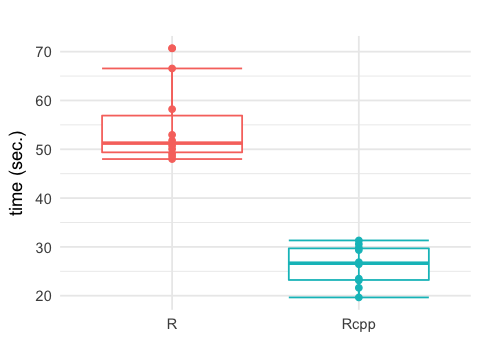

In [106]:
p_fit_times <- as.data.frame(rbind(m_hal, m_lassi)) %>%
  transmute(
    type = ifelse(stringr::str_sub(as.character(expr), 1, 3) == "hal", "R", "Rcpp"),
    time = time / 10^9
  ) %>%
  group_by(type) %>%
  ggplot(., aes(x = type, y = time, colour = type)) + geom_boxplot() + geom_point() +
   stat_boxplot(geom ='errorbar') +  xlab("") + ylab("time (sec.)") + ggtitle("") +
   theme_minimal() + theme(legend.position = "none")
p_fit_times

## HAL9000 Performance: Prediction Accuracy

In-sample prediction accuracy:

In [112]:
# training sample prediction for HAL vs HAL9000
mse <- function(preds, y) {
    mean((preds - y)^2)
}
preds_hal <- predict(hal_fit, x, verbose = FALSE)
preds_lassi <- predict(lassi_fit, x)

mse_hal <- mse(preds_hal, y)
mse_lassi <- mse(preds_lassi, y)

mse_hal
mse_lassi

[1] 0.02847709

[1] 0.03913196

Out-of-bag (OOB) prediction accuracy:

In [114]:
oob_hal <- predict(hal_fit, test_x, verbose = FALSE)
oob_lassi <- predict(lassi_fit, test_x)

oob_hal_mse <- mse(oob_hal, test_y)
oob_lassi_mse <- mse(oob_lassi, test_y)

oob_hal_mse
oob_lassi_mse

[1] 0.3804024

[1] 0.3523936

## HAL9000: What's under the hood?

We can squash the HAL9000 fit object to save memory (and time, due to memory allocation system calls). Let's take a look at whether this impacts performance at all.

In [117]:
squashed_lassi <- squash_hal_fit(lassi_fit)
c(object.size(squashed_lassi), object.size(lassi_fit))

# verify squashing doesn't impact prediction
sq_preds <- predict(lassi_fit, x)
cbind(preds, sq_preds)

sq_oob_lassi <- predict(lassi_fit, test_x)
cbind(oob_lassi, sq_oob_lassi)

[1]  110416 4222872

preds,sq_preds
0.32763828,0.35713205
-0.59829092,-0.52897075
-0.08455141,-0.12366718
0.03302364,0.06973101
0.05785975,0.09773141
0.06662323,0.07490065
-0.15210716,-0.12834282
0.07331256,0.02269795
-0.12504380,-0.16138027
-0.76330626,-0.65878238


oob_lassi,sq_oob_lassi
-0.341705925,-0.341705925
0.296607531,0.296607531
0.268675846,0.268675846
0.490135330,0.490135330
-0.048658085,-0.048658085
0.764912181,0.764912181
0.583542436,0.583542436
-0.462750320,-0.462750320
-0.313672726,-0.313672726
0.408776918,0.408776918


## Discussion

* ...
* ...
* ...
* ...